#  Asymmetric payoffs

The work done in the previous notebook, with Merton shares and so on, is true in the limit of small expected returns, i.e. small price moves -- often meaning small intervals of time.

But if you have larger price moves, and are thinking over longer investment horizons, then these approximations are going to break down. 

One way to see this is that we have quite different preferences when we are offered to make bets with asymmetric payoffs.

In [1]:
import polars as pl 
from polars import col
import seaborn as sb 
import numpy as np 
import matplotlib.pyplot as plt
from findec import crra_utility, certainty_equivalent_return

plt.style.use("../matplotlibrc")

In [2]:
df = pl.DataFrame(
    {
        "bet_type": ["positively_asymmetric", "symmetric", "negatively_asymmetric"],
        "probability_of_profit": [0.2, 0.5, 0.8],
        "probability_of_loss": [0.8, 0.5, 0.2],
        "profit": [0.45, 0.25, 0.15],
        "loss": [-0.05, -0.15, -0.35],
    }
)

df = df.with_columns(
    (col("probability_of_profit")*col("profit") + col("probability_of_loss")*col("loss")).alias("expected_gain")    
).with_columns(
    (col("probability_of_profit") * (col("profit") - col("expected_gain"))**2 + col("probability_of_loss") * (col("loss") - col("expected_gain"))**2).sqrt().alias("risk")
).with_columns(
    (col("expected_gain") / col("risk")).alias("sharpe_ratio")
)

df

bet_type,probability_of_profit,probability_of_loss,profit,loss,expected_gain,risk,sharpe_ratio
str,f64,f64,f64,f64,f64,f64,f64
"""positively_asymmetric""",0.2,0.8,0.45,-0.05,0.05,0.2,0.25
"""symmetric""",0.5,0.5,0.25,-0.15,0.05,0.2,0.25
"""negatively_asymmetric""",0.8,0.2,0.15,-0.35,0.05,0.2,0.25


If we made our investment decisions purely based on Sharpe/expected gain (which is all we depend upon in the previous notebook), then we should be indifferent amongst these three bets.

Let's see what happens when we compute expected utility and certainty-equivalent returns.

In [3]:
GAMMA = 2.

In [4]:
fraction_of_wealth_to_bet = np.linspace(0, 1, 101)

In [5]:
df_over_f = []
for f in fraction_of_wealth_to_bet:
    df_over_f.append(df.with_columns(pl.lit(f, dtype=pl.Float32()).alias("fraction_of_wealth_to_bet")))
df_over_f = pl.concat(df_over_f)

$$W=W_0[k(1+R_p) + (1-k)]$$

In [6]:
initial_wealth = 1.0

df_over_f = (
    df_over_f.with_columns(
        (
            initial_wealth * col("fraction_of_wealth_to_bet") * (1.0 + col("profit"))
            + initial_wealth * (1.0 - col("fraction_of_wealth_to_bet"))
        ).alias("final_wealth_given_profit"),
        (
            initial_wealth * col("fraction_of_wealth_to_bet") * (1.0 + col("loss"))
            + initial_wealth * (1.0 - col("fraction_of_wealth_to_bet"))
        ).alias("final_wealth_given_loss"),
    )
    .with_columns(
        col("final_wealth_given_profit")
        .map_elements(
            lambda profit: crra_utility(profit, gamma=GAMMA),
            return_dtype=pl.Float32(),
        )
        .alias("profit_utility"),
        col("final_wealth_given_loss")
        .map_elements(
            lambda loss: crra_utility(loss, gamma=GAMMA),
            return_dtype=pl.Float32(),
        )
        .alias("loss_utility"),
    )
    .with_columns(
        (
            col("probability_of_profit") * col("profit_utility")
            + col("probability_of_loss") * col("loss_utility")
        ).alias("expected_utility")
    )
    .with_columns(
        col("expected_utility")
        .map_elements(
            lambda u: certainty_equivalent_return(
                initial_wealth=initial_wealth, expected_utility=u, gamma=GAMMA
            ),
            return_dtype=pl.Float32(),
        )
        .alias("certainty_equivalent_return")
    )
)

In [12]:
optima = df_over_f.sort("certainty_equivalent_return", descending=True).group_by("bet_type").agg(col("fraction_of_wealth_to_bet", "certainty_equivalent_return").first())

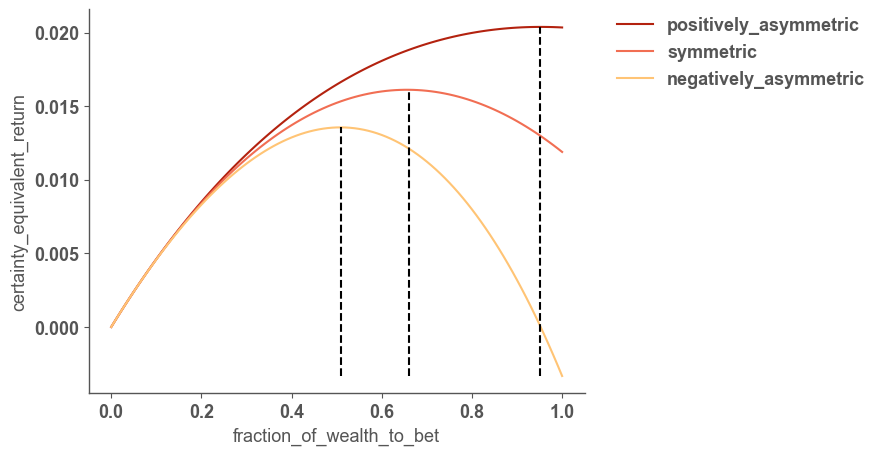

In [19]:
ax = sb.lineplot(
    df_over_f, x="fraction_of_wealth_to_bet", y="certainty_equivalent_return", hue="bet_type"
)

ax.vlines(x=optima["fraction_of_wealth_to_bet"], ymin=df_over_f["certainty_equivalent_return"].min(), ymax=optima["certainty_equivalent_return"], linestyles="dashed", colors="black")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [ ]:
df.sort("bet_type")

bet_type,probability_of_profit,probability_of_loss,profit,loss,expected_gain,risk,sharpe_ratio
str,f64,f64,f64,f64,f64,f64,f64
"""negatively_asymmetric""",0.8,0.2,0.15,-0.35,0.05,0.2,0.25
"""positively_asymmetric""",0.2,0.8,0.45,-0.05,0.05,0.2,0.25
"""symmetric""",0.5,0.5,0.25,-0.15,0.05,0.2,0.25


In [22]:
optima.sort("bet_type")

bet_type,fraction_of_wealth_to_bet,certainty_equivalent_return
str,f32,f32
"""negatively_asymmetric""",0.51,0.013576
"""positively_asymmetric""",0.95,0.020408
"""symmetric""",0.66,0.016133


Observations:

- We put quite different amounts of our wealth into these three bets, despite them all having the same Sharpe ratio
- The risk-equivalent return across the bets is also quite different. The positively asymmetric bet has a RER of 2% whereas the negatively asymmetric bet has a RER of only 1.4%.
- We therefore prefer the positively asymmetric bet (small chance of large profit, large chance of small loss) quite a bit more than a negatively asymmetric bet (large chance of small profit, small change of large profit), given fixed Sharpe.